In [64]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new/")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# TriplePandelSPE/JAX stuff
from lib.simdata_i3 import I3SimHandler
from lib.geo import center_track_pos_and_time_based_on_data, closest_distance_dom_track_v, get_xyz_from_zenith_azimuth
from lib.network import get_network_eval_v_fn
from lib.charge_network import get_charge_network_eval_v_fn
from dom_track_eval import get_eval_network_doms_and_track_w_charge as get_eval_network_doms_and_track

In [209]:
# Number of scan points on 1D
n_eval = 20 # making it a 20x20 grid

# Scan range (truth +/- dzen, +/- dazi)
dzen = 0.05 # rad
dazi = 0.05 # rad

# Event Index.
event_index = 5

# Get network and eval logic.
eval_network_v = get_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/network', dtype=jnp.float32)
eval_charge_network_v = get_charge_network_eval_v_fn(bpath='/home/storage/hans/jax_reco_new/data/charge_network', dtype=jnp.float32)

eval_network_doms_and_track = get_eval_network_doms_and_track(eval_network_v, eval_charge_network_v, dtype=jnp.float32)

# Get an IceCube event.
bp = '/home/storage2/hans/i3files/21217'

#sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              os.path.join(bp, 'pulses_ds_21217_from_10000_to_20000_1_to_10TeV.ftr'),
#                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

sim_handler = I3SimHandler(os.path.join(bp, 'meta_ds_21217_from_35000_to_53530.ftr'),
                              os.path.join(bp, 'pulses_ds_21217_from_35000_to_53530.ftr'),
                              '/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')

meta, pulses = sim_handler.get_event_data(event_index)
print(f"muon energy: {meta['muon_energy_at_detector']/1.e3:.1f} TeV")

muon energy: 3.4 TeV


In [210]:
event_data = sim_handler.get_per_dom_summary_from_sim_data(meta, pulses)

In [211]:
# Make MCTruth seed.
track_pos = jnp.array([meta['muon_pos_x'], meta['muon_pos_y'], meta['muon_pos_z']])
track_time = meta['muon_time']
track_zenith = meta['muon_zenith']
track_azimuth = meta['muon_azimuth']
track_src = jnp.array([track_zenith, track_azimuth])

print("original seed vertex:", track_pos)
centered_track_pos, centered_track_time = center_track_pos_and_time_based_on_data(event_data, track_pos, track_time, track_src)
print("shifted seed vertex:", centered_track_pos)

original seed vertex: [ 143.40123598  106.94081331 -815.20509865]
shifted seed vertex: [ -25.42355091  403.14288541 -154.63778486]


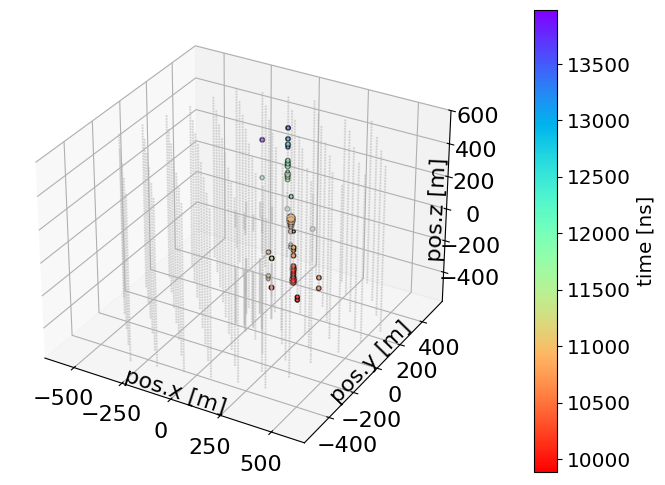

In [212]:
geo = pd.read_csv('/home/storage/hans/jax_reco_new/data/icecube/detector_geometry.csv')
df = event_data

def plot_event(df, geo=None):
    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(projection='3d')
    ax.set_xlabel('pos.x [m]', fontsize=16, labelpad=-25)
    ax.set_ylabel('pos.y [m]', fontsize=16, labelpad=-25)
    ax.set_zlabel('pos.z [m]', fontsize=16, labelpad=-25)

    idx = df['charge'] > 0
    
    try:
        im = ax.scatter(geo['x'], geo['y'], geo['z'], s=0.5, c='0.7', alpha=0.4)
    except:
        pass
    
    im = ax.scatter(df[idx]['x'], df[idx]['y'], df[idx]['z'], s=np.sqrt(df[idx]['charge']*100), c=df[idx]['time'], 
                    cmap='rainbow_r',  edgecolors='k', zorder=1000)
    ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=16)
    cb = plt.colorbar(im, orientation="vertical", pad=0.1)
    cb.set_label(label='time [ns]', size='x-large')
    cb.ax.tick_params(labelsize='x-large')
        
    plt.show()

plot_event(df, geo)

In [213]:
# Clip charge and combine into single data tensor for fitting.
fitting_event_data = jnp.array(event_data[['x', 'y', 'z', 'time', 'charge']].to_numpy())

In [194]:
logits, av, bv, geo_time, predicted_charge = eval_network_doms_and_track(fitting_event_data[:, :3], centered_track_pos, track_src)

In [195]:
predicted_charge = jnp.squeeze(jnp.sum(fitting_event_data[:, 4]) / jnp.sum(predicted_charge) * predicted_charge)

In [196]:
import matplotlib.pyplot as plt

In [197]:
print(predicted_charge.shape)

(85,)


(0.1, 1000)

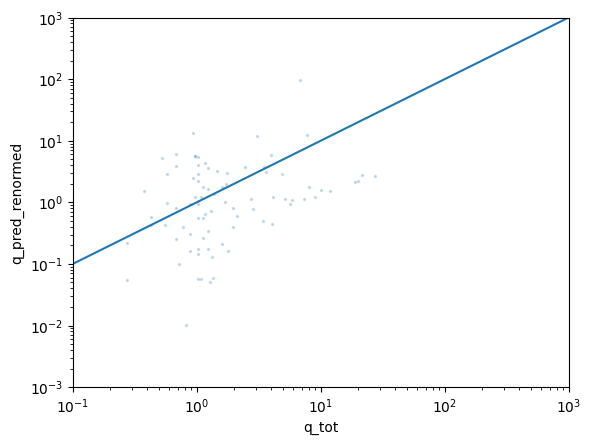

In [198]:
fig, ax = plt.subplots()
plt.scatter(fitting_event_data[:, 4], predicted_charge, s=2, alpha=0.2)
plt.plot([0.001, 1000], [0.001, 1000])
plt.xlabel('q_tot')
plt.ylabel('q_pred_renormed')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.001, 10**3])
plt.xlim([0.1, 10**3])

In [199]:
first_hit_times = fitting_event_data[:, 3]
delay_time = first_hit_times - (geo_time + centered_track_time)

In [200]:
track_dir_xyz = get_xyz_from_zenith_azimuth(track_src)
dists = closest_distance_dom_track_v(fitting_event_data[:, :3], centered_track_pos, track_dir_xyz)

In [201]:
print(np.sort(delay_time))

[3.01413832e-02 7.59531754e+00 1.76915549e+01 2.16414466e+01
 2.25514952e+01 2.81056172e+01 2.85895658e+01 3.12631240e+01
 3.53379587e+01 3.56867167e+01 3.58572742e+01 3.74001306e+01
 3.90608813e+01 4.71682997e+01 5.21614794e+01 5.30517539e+01
 5.52500135e+01 6.47497271e+01 6.55649542e+01 6.86119382e+01
 7.06346318e+01 7.27147858e+01 9.25408081e+01 1.03865160e+02
 1.37472094e+02 1.46124797e+02 1.47328057e+02 1.71610215e+02
 1.98058697e+02 2.24091975e+02 2.34407263e+02 2.45691995e+02
 2.47571533e+02 2.61931168e+02 2.73760679e+02 3.03671203e+02
 3.56116116e+02 3.74129838e+02 3.75210728e+02 3.79916565e+02
 4.04807692e+02 4.05603521e+02 4.46355222e+02 4.48082260e+02
 4.61968840e+02 4.68046588e+02 4.69741618e+02 4.84277389e+02
 4.96505902e+02 4.96567303e+02 4.96919550e+02 5.08332220e+02
 5.21710521e+02 5.40042087e+02 5.40209139e+02 5.40944605e+02
 5.44957578e+02 5.47258540e+02 6.00697835e+02 6.05284629e+02
 6.06952693e+02 6.44402812e+02 6.48962724e+02 6.64611527e+02
 7.47901464e+02 7.639101

In [205]:
np.sort(delay_time[predicted_charge < 0.05])

array([1300.39182994])

In [206]:
print(dists[predicted_charge < 0.05])

[233.56129217]


(1, 1000)

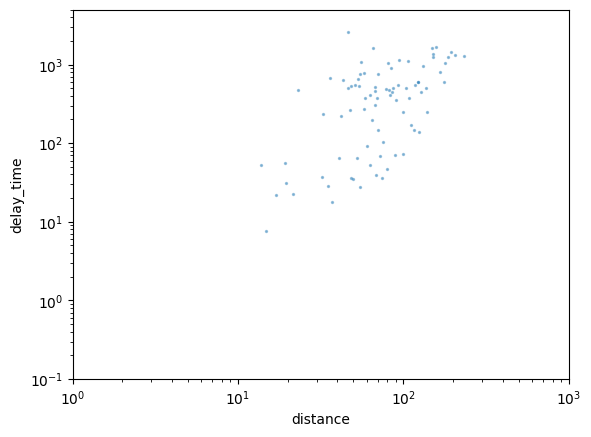

In [204]:
fig, ax = plt.subplots()
plt.scatter(dists, delay_time, s=2, alpha=0.4)
plt.scatter(dists, -delay_time, s=2, alpha=0.4)
plt.xlabel('distance')
plt.ylabel('delay_time')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 5*10**3])
plt.xlim([1, 10**3])

(1, 1000)

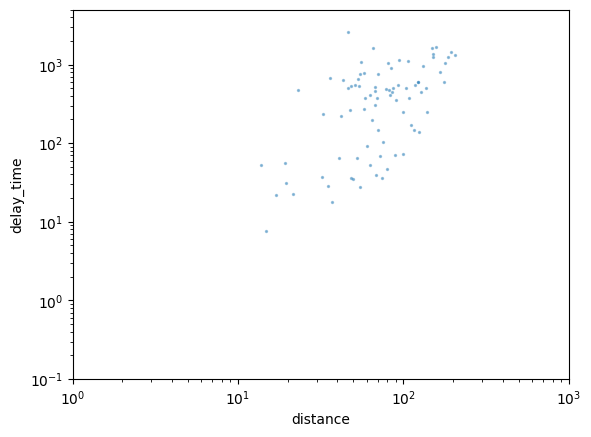

In [208]:
ix = predicted_charge > 0.05

fig, ax = plt.subplots()
plt.scatter(dists[ix], delay_time[ix], s=2, alpha=0.4)
plt.scatter(dists[ix], -delay_time[ix], s=2, alpha=0.4)
plt.xlabel('distance')
plt.ylabel('delay_time')
plt.yscale('log')
plt.xscale('log')
plt.ylim([0.1, 5*10**3])
plt.xlim([1, 10**3])

In [207]:
np.sort(delay_time[predicted_charge < 0.05])

array([1300.39182994])